In [26]:
import argparse
import json
import pickle
import json
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nilearn.datasets import fetch_neurovault, fetch_atlas_difumo
from nilearn.maskers import NiftiMapsMasker
from nilearn.image import resample_to_img, index_img
import nibabel

# Loading 3D data

In [33]:
from ai4sipmbda.utils.fetching import fetch_nv
nv_path= "../../Data/neurovault/"
nv_filepath = "../../cache/"
download=False
max_images=10
neurovault = fetch_nv(nv_path, nv_filepath , download, max_images= max_images)


Load pre-fetched data from Neurovault...
Number of (down)loaded fMRI files: 10


In [34]:
### Show image example

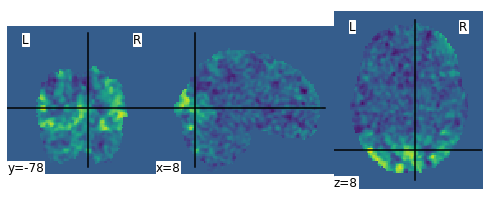

In [35]:
from nilearn import plotting
plotting.plot_img(neurovault["images"][0])

# Projection 3D data into DiFuMo space

In [37]:
from nilearn.datasets import fetch_atlas_difumo
import nibabel
# DiFuMo dictionary matrix
difumo = fetch_atlas_difumo(dimension=1024)

difumo_maps = nibabel.load(difumo["maps"])

difumo_maps.shape

/Users/nastassya.horlava/opt/anaconda3/envs/aisip/lib/python3.9/site-packages/nilearn/datasets/atlas.py:130: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


(104, 123, 104, 1024)

In [38]:
# One activation map

first_image = nibabel.load(neurovault["images"][0])

In [40]:
from nilearn.image import resample_to_img
# This allows to resample the DiFuMo atlas to the HCP image shape

resampled_difumo_maps = resample_to_img(difumo_maps, first_image, interpolation="nearest")

resampled_difumo_maps.shape

(91, 109, 91, 1024)

In [42]:
from nilearn.maskers import NiftiMapsMasker

# This object is used compute and apply the brain mask and difumo projection matrix

masker = NiftiMapsMasker(resampled_difumo_maps)

In [43]:
# This operation takes a lot of time and cannot be done on the fly

projected_img = masker.fit_transform(first_image)

In [44]:
projected_img.shape

(1, 1024)

To speed things up and make it compatible with on-the-fly computation, we will need to do the computations ourselves, saving some matrix in the RAM.

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 1024)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [   4   91  109   91 1024    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.00606863
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : un

<ipython-input-48-c3ed9f1e6b52>:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  maps_data = maps_img.get_data()


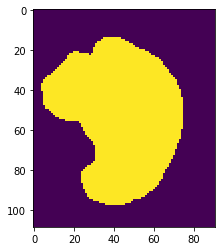

In [48]:
import numpy as np

# Here we threshold the first image to get a mask of the brain voxels
# and reduce the dimension of the projecting matrix

maps_img = masker.maps_img_
print(maps_img)
maps_data = maps_img.get_data()
mask = np.sum(maps_data, axis= -1)
# mask = mask > np.percentile(mask, 75)
mask = mask > 0
plt.imshow(mask[45])

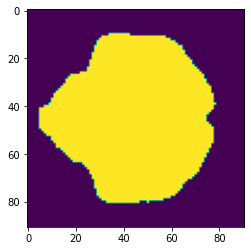

In [49]:
import matplotlib.pyplot as plt
plt.imshow(mask[:, 45])

In [50]:
# And this mask can be used to compute the matrix Z used to project onto the DiFuMo space manually

Z = maps_data[mask, :]
print(Z.shape)

(221091, 1024)


In [51]:
# To project a new image onto the DiFuMo space, we compute the pseudo-inverse Z+ of Z once and store it

pseudo_inv_Z = np.linalg.pinv(Z)

In [52]:
pseudo_inv_Z.shape

(1024, 221091)

In [53]:
other_img = nibabel.load(neurovault["images"][1])

In [54]:
# Then we can use Z+ to compute the DiFuMo projection efficiently, which can be done on-the-fly

projected_img_2 = pseudo_inv_Z.dot(other_img.get_data()[mask])

<ipython-input-54-2cb1d1492cf0>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  projected_img_2 = pseudo_inv_Z.dot(other_img.get_data()[mask])


In [55]:
projected_img_2.shape

(1024,)

In [59]:
# We should probably save the mask, Z and Z+ on disk for later use
from pathlib import Path
import os
difumo_matrices_dir = Path("../../hcp900_difumo_matrices/")
os.makedirs(difumo_matrices_dir, exist_ok=True)

np.save(difumo_matrices_dir / "mask", mask)
np.save(difumo_matrices_dir / "Z", Z)
np.save(difumo_matrices_dir / "Zinv", pseudo_inv_Z)